## Imports  

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer


## Load the data

### Load the SmartMeters data

In [3]:
# Load data, make sure that you set the correct file path
data = pd.read_csv('energy_data.csv', delimiter=';')

# Select all SM with complete data
clean_sm = pd.read_csv('CleanSmartmeterData.csv', delimiter=',')
data = data[data['PROFILE'].isin(clean_sm['PROFILE'])]

# Convert DATEFROM and TIMEFROM into a single datetime column
data['datetime'] = pd.to_datetime(data['DATEFROM'] + ' ' + data['TIMEFROM'])

print(data.head())

   PROFILE    DATEFROM  TIMEFROM  VALUE UNIT            datetime
0   740105  2023.03.01  00:00:00  0.880  KWH 2023-03-01 00:00:00
1   740105  2023.03.01  00:15:00  0.968  KWH 2023-03-01 00:15:00
2   740105  2023.03.01  00:30:00  0.906  KWH 2023-03-01 00:30:00
3   740105  2023.03.01  00:45:00  0.916  KWH 2023-03-01 00:45:00
4   740105  2023.03.01  01:00:00  0.977  KWH 2023-03-01 01:00:00


### Load the temperture data

Source of the data: https://opendata.swiss/de/dataset/stadtklima-zurich-bereinigte-temperaturmessungen-messnetz-meteoblue/resource/09815773-1d80-443f-8e23-e7c9f763ebe0

In [4]:
# Load data
temperature_data_23 = pd.read_csv('temperature_meteoblue.csv', delimiter=',')
temperature_data_24 = pd.read_csv('temperature_data_2024.csv', delimiter=',')

# Concatenate the two dataframes vertically
temperature_data = pd.concat([temperature_data_23, temperature_data_24], ignore_index=True)

# Convert timezone to UTC + 2
# Convert 'timestamp' to datetime format
temperature_data['timestamp'] = pd.to_datetime(temperature_data['timestamp'])
# Convert from UTC to UTC+2
temperature_data['timestamp'] = temperature_data['timestamp'].dt.tz_convert('Europe/Berlin')
temperature_data['timestamp'] = temperature_data['timestamp'].dt.tz_localize(None)


# Select one location
loc_temp_data = temperature_data.loc[temperature_data['locationID'] == 'B12']

print(loc_temp_data.head())  

data_2023_01_03 = data[data['datetime'].dt.date == pd.to_datetime('2023-01-03').date()]
print(data_2023_01_03)



              timestamp locationID parameter  value  qc_flag  rc_flag
2   2023-01-01 01:00:00        B12         T   12.0        0        0
93  2023-01-01 01:15:00        B12         T   12.0        0        0
184 2023-01-01 01:30:00        B12         T   12.2        0        0
275 2023-01-01 01:45:00        B12         T   12.5        0        0
366 2023-01-01 02:00:00        B12         T   13.0        0        0
Empty DataFrame
Columns: [PROFILE, DATEFROM, TIMEFROM, VALUE, UNIT, datetime]
Index: []


# Merge the tempearture with the data

In [5]:
# Umbenennen der 'value'-Spalte in 'temperature' in loc_temp_data
loc_temp_data = loc_temp_data.rename(columns={'value': 'temperature'})

print(loc_temp_data.head())
print('---------------------------------------------')

print(data.head())

print('---------------------------------------------')

# Zusammenführen der DataFrames
merged_data = pd.merge(data, loc_temp_data, left_on='datetime', right_on='timestamp', how='left')

print(merged_data.head())

              timestamp locationID parameter  temperature  qc_flag  rc_flag
2   2023-01-01 01:00:00        B12         T         12.0        0        0
93  2023-01-01 01:15:00        B12         T         12.0        0        0
184 2023-01-01 01:30:00        B12         T         12.2        0        0
275 2023-01-01 01:45:00        B12         T         12.5        0        0
366 2023-01-01 02:00:00        B12         T         13.0        0        0
---------------------------------------------
   PROFILE    DATEFROM  TIMEFROM  VALUE UNIT            datetime
0   740105  2023.03.01  00:00:00  0.880  KWH 2023-03-01 00:00:00
1   740105  2023.03.01  00:15:00  0.968  KWH 2023-03-01 00:15:00
2   740105  2023.03.01  00:30:00  0.906  KWH 2023-03-01 00:30:00
3   740105  2023.03.01  00:45:00  0.916  KWH 2023-03-01 00:45:00
4   740105  2023.03.01  01:00:00  0.977  KWH 2023-03-01 01:00:00
---------------------------------------------
   PROFILE    DATEFROM  TIMEFROM  VALUE UNIT            dateti

## Feature Engineering

In [6]:
# Feature Engineering, this part needs more work
merged_data['minute'] = merged_data['datetime'].dt.minute # Minute
merged_data['hour'] = merged_data['datetime'].dt.hour # Hour of day
merged_data['day_of_week'] = merged_data['datetime'].dt.dayofweek # Weekday
merged_data['season'] = merged_data['datetime'].dt.quarter # Season
merged_data['temperature'] = merged_data['temperature'] # Season


print(merged_data.columns)

# Select features and target
# X = merged_data[['hour', 'minute', 'day_of_week', 'season']] 
# y = merged_data['VALUE']

# Select features and target
X = merged_data[['hour', 'minute', 'day_of_week', 'season', 'temperature']]
y = merged_data['VALUE']






Index(['PROFILE', 'DATEFROM', 'TIMEFROM', 'VALUE', 'UNIT', 'datetime',
       'timestamp', 'locationID', 'parameter', 'temperature', 'qc_flag',
       'rc_flag', 'minute', 'hour', 'day_of_week', 'season'],
      dtype='object')


## Spit data inot training and testing sets

In [7]:
# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


# Models

## RandomForestRegressor

Root Mean Squared Error: 0.3208368368550296


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/base.py:457: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/base.py:457: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(


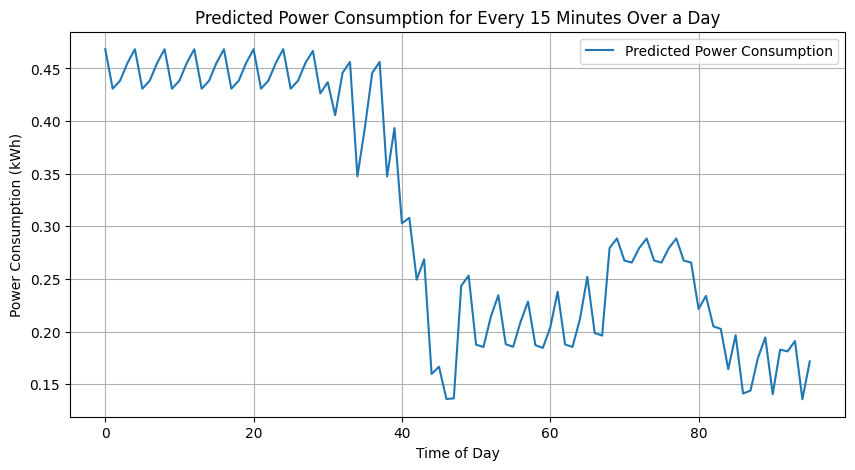

In [8]:
from sklearn.impute import SimpleImputer
# Filler
# Use mean as fill value
imputer = SimpleImputer(strategy='mean')

# Fit on the training data
imputer.fit(X_train)

# Create an imputer transformer to fill in missing values with the mean
imputer = SimpleImputer(strategy='mean')

# Fit and transform the training data
X_train = imputer.fit_transform(X_train)

# Transform the testing data
X_test = imputer.transform(X_test)

# Initialize and train the model with RandomForestRegressor 

# Initialize and train the model with https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Make predictions
predictions = model.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, predictions)
rmse = np.sqrt(mse)
print(f'Root Mean Squared Error: {rmse}')

# Generate data points for an entire day in 15-minute intervals
intervals_per_hour = 4
hours = np.repeat(np.arange(24), intervals_per_hour)
minutes = np.tile(np.arange(0, 60, 15), 24)
day_of_week = np.zeros(24 * intervals_per_hour)  # Assuming Monday (day_of_week = 0)
temperatures = X['temperature'].mean() * np.ones(24 * intervals_per_hour)  # Average temperature

# For new data point prediction, include a temperature value
new_data = pd.DataFrame({'hour': [2], 'minute': [15], 'day_of_week': [0], 'season': [1], 'temperature': [20]})

# Predict the new data point
new_prediction = model.predict(new_data)

# For predicting the whole day, include temperature values
new_data = pd.DataFrame({
    'hour': hours,
    'minute': minutes,
    'day_of_week': day_of_week,
    'season': 1,
    'temperature': temperatures,

})

# Predict the whole day
day_predictions = model.predict(new_data)

# Plotting
plt.figure(figsize=(10, 5))
plt.plot(day_predictions, label='Predicted Power Consumption')
# plt.xticks(ticks=np.arange(0, 96, 4), labels=[f'{i}:00' for i in range(24)])
plt.xlabel('Time of Day')
plt.ylabel('Power Consumption (kWh)')
plt.title('Predicted Power Consumption for Every 15 Minutes Over a Day')
plt.grid(True)
plt.legend()
plt.show()

In [9]:
# Compute standart deviation of value
standard_deviation = np.std(y)
print(f'Standard Deviation of the target variable: {standard_deviation}')

Standard Deviation of the target variable: 0.3536404136847945


## Support Vector Machines
SVR (Support Vector Regression): The regression version of SVM can be very powerful, especially in cases of non-linear relationships due to its flexibility in choosing kernels.
https://scikit-learn.org/stable/modules/svm.html


# Notes of the QA

- 